# Lab 08 - Distances and PCA

Name: Kartikeya Sharma  
Class: CSCI 349 - Intro to Data Mining  
Semester: 2021SP  
Instructor: Brian King  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
# additional imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial.distance import pdist, squareform

#### 1) [P] Set up a pandas data frame with the following 8 observations and 3 variables:<br/><br/>*output below matches that in assignment*<br/><br/>Be sure to set the types of each variable as follows:<br/><br/>• ```test1```: Nominal, levels = { "A", "B", C" }<br/><br/>• ```test2```: Ordinal, levels = { "poor", "fair", "good", "excellent" }<br/><br/>• ```test3```: Numeric<br/><br/>Use ```pd.Categorical``` to properly set up categorical variables (i.e. test1 and test2) and pay attention to the ```ordered``` parameter. Name the data frame ```df```. Set the ```index``` correctly to match the row names in the table above.<br/><br/>Display the df data frame, and then show the output of ```info()``` method to show the type of each variable in ```df```.

In [2]:
df = pd.DataFrame()
df["test1"] = pd.Categorical(
    ["A", "C", "C", "B", "A", "B", "C", "B"],
    categories=["A", "B", "C"], 
    ordered=False)
df["test2"] = pd.Categorical(
    ["excellent", "fair", "good", "fair", 
     "poor", "excellent", "good", "good"],
    categories=["poor", "fair", "good", "excellent"], 
    ordered=True)
df["test3"] = pd.Series([25, 32, 60, 53, 23, 37, 45, 49])
df.index = "A" + df.index.astype("str")

display(df)

,test1,test2,test3
A0,A,excellent,25
A1,C,fair,32
A2,C,good,60
A3,B,fair,53
A4,A,poor,23
A5,B,excellent,37
A6,C,good,45
A7,B,good,49


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, A0 to A7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   test1   8 non-null      category
 1   test2   8 non-null      category
 2   test3   8 non-null      int64   
dtypes: category(2), int64(1)
memory usage: 480.0+ bytes


#### 2) [PM] Show the output of ```df.describe(include='all')```. What does the ```include='all'``` parameter do?

In [4]:
df.describe() # for comparison

,test3
count,8.000000
mean,40.500000
std,13.416408
min,23.000000
25%,30.250000
50%,41.000000
75%,50.000000
max,60.000000


In [5]:
df.describe(include='all')

,test1,test2,test3
count,8,8,8.000000
unique,3,4,NaN
top,B,good,NaN
freq,3,3,NaN
mean,NaN,NaN,40.500000
std,NaN,NaN,13.416408
min,NaN,NaN,23.000000
25%,NaN,NaN,30.250000
50%,NaN,NaN,41.000000
75%,NaN,NaN,50.000000


The ```include='all'``` parameter "\[generates\] descriptive statistics" for all columns (not only the ones containing numeric data) of the pandas.DataFrame object calling the pandas.DataFrame.describe function.<sup>1</sup>

Sources:
1. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

#### 3) [PM] Show the output of ```df.test1.cat.categories```, and ```df.test2.cat.categories```. What is this showing? Does it work for ```df.test3.cat.categories```? (If not, then comment this line out.)

In [6]:
# returns an "accessor object for categorical properties"
# source: https://pandas.pydata.org/docs/reference/api/pandas.Series.cat.html
df.test1.cat # only used for comparison

In [7]:
df.test1.cat.categories

Index(['A', 'B', 'C'], dtype='object')

In [8]:
df.test2.cat.categories

Index(['poor', 'fair', 'good', 'excellent'], dtype='object')

In [9]:
# throws "AttributeError: 
# Can only use .cat accessor with a 'category' dtype"
# df.test3.cat.categories

It displays the various categories (discrete values) that the categorical variable, generally represented by the column, can take on.  It does not work for ```df.test3.cat.categories``` because the entries in that column can take on a vast range of numeric values (64-bit integers), rather than a contained discrete set of values/labels/categories. 

#### 4) [PM] Show the output of ```df.test1.cat.codes```, and ```df.test2.cat.codes```. What is this showing?

In [10]:
df.test1.cat.codes

A0    0
A1    2
A2    2
A3    1
A4    0
A5    1
A6    2
A7    1
dtype: int8

In [11]:
df.test2.cat.codes

A0    3
A1    1
A2    2
A3    1
A4    0
A5    3
A6    2
A7    2
dtype: int8

It shows a pandas.Series object containing a list of category codes, which are the categorical indices of the corresponding categorical values contained within the pandas.Series object from which the cat.codes property was retrieved. <sup>1</sup> 
 
Source: 
1. https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Categorical.codes.html

#### 5) [P] Report the counts of each level of the categorical variables.

In [12]:
df.test1.value_counts()

B    3
C    3
A    2
Name: test1, dtype: int64

In [13]:
df.test2.value_counts()

good         3
fair         2
excellent    2
poor         1
Name: test2, dtype: int64

#### 6) [P] Report a cross tabulation (i.e. contingency table) between ```test1``` and ```test2```. Include the margins (i.e. the sum of the rows and the columns) in your reported table (HINT: Look up pandas ```crosstab()``` function)

In [14]:
c_tab = pd.crosstab(df.test1, df.test2, margins=True)

display(c_tab) # to verify

test2,poor,fair,good,excellent,All
test1,,,,,
A,1,0,0,1,2
B,0,1,1,1,3
C,0,1,2,0,3
All,1,2,3,2,8


#### 7) [P] From the previous table, store the contingency table without the margins in a variable called ```observed```

In [15]:
observed = c_tab.iloc[:-1, :-1]

display(observed) # to verify 

test2,poor,fair,good,excellent
test1,,,,
A,1,0,0,1
B,0,1,1,1
C,0,1,2,0


#### 8) [P] Run a chi-squared test to determine whether test1 and test2 are dependent. Use the contingency table from the previous step. Clearly report the chi2 statistic, the p value, and the degrees of freedom, and then use the p-value to clearly state whether test1 and test2 are independent (assume p=0.05 threshold to test for independence)

In [16]:
# parameters
p_val_threshold = 0.5

In [17]:
observed_chi2_result = stats.chi2_contingency(
    observed, 
    correction=False
)

chi2_stat = observed_chi2_result[0]
p_val = observed_chi2_result[1]
deg_of_free = observed_chi2_result[2]

print("chi2 statistic: " + str(chi2_stat))
print("p value: " + str(p_val))
print("degrees of freedom: " + str(deg_of_free))
print()
if p_val <= p_val_threshold: 
    print("test1 and test2 have a relationship because the p " + \
          "value from their chi-squared test was " + str(p_val) + \
          ", which is less than or equal to the p value " + \
          "threshold of independence for the test of " + \
          str(p_val_threshold) + ".")
else:
        print("test1 and test2 are independent because the p " + \
          "value from their chi-squared test was " + str(p_val) + \
          ", which is greater than the p value " + \
          "threshold of independence for the test of " + \
          str(p_val_threshold) + ".")

chi2 statistic: 6.444444444444444
p value: 0.37528525266160834
degrees of freedom: 6

test1 and test2 have a relationship because the p value from their chi-squared test was 0.37528525266160834, which is less than or equal to the p value threshold of independence for the test of 0.5.


#### 9) [P] Create a new data frame called ```df_num```, that represents a numeric version of the above. Do NOT do any rescaling of your variables yet!<br/><br/>NOTE: If you do this from a dataframe that has the categorical variables set up properly, then this step is simple to do. The two choices I generally follow are either: 1) use the ```cat``` member of your categorical data, which stores a ```CategoricalAccessor``` object (look it up), or use one of the encoders in the ```sklearn.preprocessing``` module. The first option is easier, and yet another reason why it's so important to take the time to preprocess your data as correctly and error-free as possible.<br/><br/>Your resulting data frame at the end of this step should be as follows:<br/><br/>*output below matches that in assignment*

In [18]:
df_num = df.copy(deep=True)

df_num.test1 = df_num.test1.cat.codes
df_num.test2 = df_num.test2.cat.codes

df_num

,test1,test2,test3
A0,0,3,25
A1,2,1,32
A2,2,2,60
A3,1,1,53
A4,0,0,23
A5,1,3,37
A6,2,2,45
A7,1,2,49


#### 10) [P] As you learned in lecture, you must rescale your data to fall on a similar scale. There are different approaches to doing so. A standardized z-score is among the most common, but not necessarily always the best approach, especially when you are dealing with numeric representations of true categorical data. Rescaling your data to all fall between 0 and 1 is also a common approach, particularly when you have categorical data.<br/><br/>Let's first try to rescale our data to all fall between the values of 0 and 1. Use the ```MinMaxScaler``` in ```sklearn.preprocessing``` to rescale all variables to fall between 0 and 1. Store the transformed data as a pandas data frame called ```df_num_zeroone```,. Your result should look as follows:<br/><br/>*output below matches that in assignment*

In [19]:
scaler = MinMaxScaler()

df_num_zeroone = pd.DataFrame(scaler.fit_transform(df_num),
                              index=df_num.index,
                              columns=df_num.columns)

df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.054054
A1,1.0,0.333333,0.243243
A2,1.0,0.666667,1.000000
A3,0.5,0.333333,0.810811
A4,0.0,0.000000,0.000000
A5,0.5,1.000000,0.378378
A6,1.0,0.666667,0.594595
A7,0.5,0.666667,0.702703


11) [P] Notice the value of ```test3```. Quite often, when we have solid knowledge of what we expect our range to be, then we can rescale our data using that knowledge. In the case of ```test3```, you learned that the data must fall between 0 and 100. Therefore, reassign ```test3``` so that the min and max before rescaling are assuming to be between 0 and 100, respectively. (i.e. simply divide the original variable by 100)

In [20]:
df_num_zeroone.test3 = df_num.test3/100

df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.25
A1,1.0,0.333333,0.32
A2,1.0,0.666667,0.60
A3,0.5,0.333333,0.53
A4,0.0,0.000000,0.23
A5,0.5,1.000000,0.37
A6,1.0,0.666667,0.45
A7,0.5,0.666667,0.49


#### 12) [P] Compute a single distance matrix called ```distmat_zeroone```. Use a standard Euclidean distance measure. Your reported result should be an 8x8 matrix with appropriately labeled rows and columns. (HINT – study the output of the distance matrix functions! They do not output a square matrix. As discussed in lecture you can use either ```pairwise_distances``` from scikit-learn, or the ```pdist``` and ```squareform``` functions in ```scipy.spatial.distance```). Be sure to label the rows and columns to be the index from the input dataframe. Round it to 3 significant digits.<br/><br/>Your result should look something like this:<br/><br/>*output below matches that in assignment*

In [21]:
distmat_zeroone = pd.DataFrame(pairwise_distances(df_num_zeroone),
                               index=df_num_zeroone.index,
                               columns=df_num_zeroone.index)

distmat_zeroone

,A0,A1,A2,A3,A4,A5,A6,A7
A0,0.000000,1.203887,1.110680e+00,0.879116,1.000200,0.514198,1.072898,0.647079
A1,1.203887,0.000000,4.353287e-01,0.542310,1.057928,0.834832,0.357786,0.624509
A2,1.110680,0.435329,2.107342e-08,0.604989,1.257515,0.643437,0.150000,0.511957
A3,0.879116,0.542310,6.049885e-01,0.000000,0.671648,0.685598,0.606227,0.335725
A4,1.000200,1.057928,1.257515e+00,0.671648,0.000000,1.126765,1.221820,0.872952
A5,0.514198,0.834832,6.434370e-01,0.685598,1.126765,0.000000,0.606227,0.354275
A6,1.072898,0.357786,1.500000e-01,0.606227,1.221820,0.606227,0.000000,0.501597
A7,0.647079,0.624509,5.119570e-01,0.335725,0.872952,0.354275,0.501597,0.000000


#### 13) [P] Output the top three closest pairs of observations. You MUST write Python code to report these results! Do not simply print out your distance matrix and tell me your answers! Consider that this may have been thousands of observations! Always generate reported answers in code whenever you can! <br/><br/>For each pair, output the pair of observations from the original dataframe, and the distance between them.<br/><br/>(HINT: I found this easier to do with the output of ```pdist```.)<br/><br/>For example, your first closest pair output might have output that looks as follows:<br/><br/>*output below matches that in assignment*

In [22]:
pdist(df_num_zeroone) # just to see the output

array([1.20388722, 1.11068047, 0.87911572, 1.00019998, 0.51419841,
       1.07289846, 0.64707891, 0.43532874, 0.54230987, 1.05792774,
       0.83483199, 0.3577864 , 0.6245087 , 0.60498852, 1.25751519,
       0.64343695, 0.15      , 0.51195703, 0.67164806, 0.68559787,
       0.60622695, 0.33572475, 1.12676528, 1.22182014, 0.87295157,
       0.60622695, 0.35427547, 0.50159745])

In [23]:
def print_index_labels_dist_observations(
    list_indices: np.ndarray, 
    description: str,
    df_num_scaled: pd.DataFrame,
    distmat_scaled: pd.DataFrame,
    df: pd.DataFrame=df):
    
    index_pairs = list()
    dist_matrix_dim = len(distmat_scaled.columns)
    row_counter = 0
    index_pair = None

    for index in list_indices:
        index_iter = index
        while (index_pair is None):
            if index_iter >= (dist_matrix_dim - 1) - row_counter: # -1 for num cols
                index_iter-=(dist_matrix_dim - 1) - row_counter    
                row_counter+=1
            else:
                index_pair = [row_counter, index_iter+row_counter+1]
        index_pairs.append(index_pair)
        index_pair = None
        row_counter = 0

    
    label_pairs = list()
    for index_pair in index_pairs:
        label_pairs.append([
            distmat_scaled.columns[index_pair[0]], 
            distmat_scaled.columns[index_pair[1]]
        ])

    for i in range(len(label_pairs)):
        print(
            description + ": # " + str(i) + " : " + str(label_pairs[i]) + \
            " dist=" + str("%.3f" %
                round(distmat_scaled.loc[label_pairs[i][0], label_pairs[i][1]], 3)
            )
        )
        print(df.loc[[label_pairs[i][0], label_pairs[i][1]]])
        print()

In [24]:
# parameter
n_closest_pairs = 3

In [25]:
n_closest_indices = pdist(df_num_zeroone).argsort()[:n_closest_pairs]
print_index_labels_dist_observations(n_closest_indices, 
                                     "Closest",
                                     df_num_zeroone,
                                     distmat_zeroone)

Closest: # 0 : ['A2', 'A6'] dist=0.150
   test1 test2  test3
A2     C  good     60
A6     C  good     45

Closest: # 1 : ['A3', 'A7'] dist=0.336
   test1 test2  test3
A3     B  fair     53
A7     B  good     49

Closest: # 2 : ['A5', 'A7'] dist=0.354
   test1      test2  test3
A5     B  excellent     37
A7     B       good     49



#### 14) [P] Now, output the three most distant (least similar) pairs of observations. Again, for each pair, output the two observations, and the distance between them

In [26]:
# parameter
n_farthest_pairs = 3

In [27]:
n_farthest_indices = np.argsort(-1*pdist(df_num_zeroone))[:n_farthest_pairs]
print_index_labels_dist_observations(n_farthest_indices, 
                                     "Farthest",
                                     df_num_zeroone,
                                     distmat_zeroone)

Farthest: # 0 : ['A2', 'A4'] dist=1.258
   test1 test2  test3
A2     C  good     60
A4     A  poor     23

Farthest: # 1 : ['A4', 'A6'] dist=1.222
   test1 test2  test3
A4     A  poor     23
A6     C  good     45

Farthest: # 2 : ['A0', 'A1'] dist=1.204
   test1      test2  test3
A0     A  excellent     25
A1     C       fair     32



#### 15) [P] Create a new data frame, ```df_num_binarized```, that stores the a *binarized* version for test1 and test2.<br/><br/>For example, ```test1``` has three distinct values, "A", "B", and "C". Therefore, you should end up with three new variables that replace the one categorical variable. Best practice is to name your variables accordingly, with the variable name prefix, and the value as a suffix, usually with an _ in between. Thus, your result for the first variable should look like:<br/><br/>*output below matches that in assignment*<br/><br/>Do this for BOTH categorical variables ```test1```, and ```test2```. However, ```test3``` is already numeric, and we scaled it between zero-one already. Thus just copy the result of ```test3``` from df_num_zeroone.<br/><br/>HINT - HOW? One approach is to use ```OneHotEncoder``` from ```sklearn.preprocessing```. For this purpose, you can set the parameter ```sparse=False``` so that you can easily view the data, and set your ```dtype=int```.<br/><br/>Your result should look something like the following:<br/><br/>*output below matches that in assignment*<br/><br/>Another approach is to use the pandas function get_dummies().

In [28]:
pd.get_dummies(df.test1, prefix="test1")

,test1_A,test1_B,test1_C
A0,1,0,0
A1,0,0,1
A2,0,0,1
A3,0,1,0
A4,1,0,0
A5,0,1,0
A6,0,0,1
A7,0,1,0


In [29]:
df_num_binarized = pd.concat([pd.get_dummies(df.test1, prefix="test1"),
                              pd.get_dummies(df.test2, prefix="test2"),
                              df_num_zeroone["test3"]],
                              axis=1)

df_num_binarized

,test1_A,test1_B,test1_C,test2_poor,test2_fair,test2_good,test2_excellent,test3
A0,1,0,0,0,0,0,1,0.25
A1,0,0,1,0,1,0,0,0.32
A2,0,0,1,0,0,1,0,0.60
A3,0,1,0,0,1,0,0,0.53
A4,1,0,0,1,0,0,0,0.23
A5,0,1,0,0,0,0,1,0.37
A6,0,0,1,0,0,1,0,0.45
A7,0,1,0,0,0,1,0,0.49


#### 16) [P] Now, compute ```distmat_binarized``` by computing the distance matrix for the ```df_binarized```.

In [30]:
distmat_binarized = pd.DataFrame(squareform(pdist(df_num_binarized)),
                                 index=df_num_binarized.index,
                                 columns=df_num_binarized.index)

distmat_binarized

,A0,A1,A2,A3,A4,A5,A6,A7
A0,0.000000,2.001225,2.030394,2.019505,1.414355,1.419296,2.009975,2.014349
A1,2.001225,0.000000,1.441666,1.429720,2.002024,2.000625,1.420176,2.007212
A2,2.030394,1.441666,0.000000,2.001225,2.033937,2.013182,0.150000,1.418485
A3,2.019505,1.429720,2.001225,0.000000,2.022375,1.423236,2.001599,1.414779
A4,1.414355,2.002024,2.033937,2.022375,0.000000,2.004894,2.012064,2.016829
A5,1.419296,2.000625,2.013182,1.423236,2.004894,0.000000,2.001599,1.419296
A6,2.009975,1.420176,0.150000,2.001599,2.012064,2.001599,0.000000,1.414779
A7,2.014349,2.007212,1.418485,1.414779,2.016829,1.419296,1.414779,0.000000


#### 17) [P] Report the three closest pairs, and the three most distant pairs from ```distmat_binarized```

In [31]:
# parameter
n_closest_pairs = 3

In [32]:
n_closest_indices = pdist(df_num_binarized).argsort()[:n_closest_pairs]
print_index_labels_dist_observations(n_closest_indices, 
                                     "Closest",
                                     df_num_binarized,
                                     distmat_binarized)

Closest: # 0 : ['A2', 'A6'] dist=0.150
   test1 test2  test3
A2     C  good     60
A6     C  good     45

Closest: # 1 : ['A0', 'A4'] dist=1.414
   test1      test2  test3
A0     A  excellent     25
A4     A       poor     23

Closest: # 2 : ['A6', 'A7'] dist=1.415
   test1 test2  test3
A6     C  good     45
A7     B  good     49



In [33]:
# parameter
n_farthest_pairs = 3

In [34]:
n_farthest_indices = np.argsort(-1*pdist(df_num_binarized))[:n_farthest_pairs]
print_index_labels_dist_observations(n_farthest_indices, 
                                     "Furthest",
                                     df_num_binarized,
                                     distmat_binarized)

Furthest: # 0 : ['A2', 'A4'] dist=2.034
   test1 test2  test3
A2     C  good     60
A4     A  poor     23

Furthest: # 1 : ['A0', 'A2'] dist=2.030
   test1      test2  test3
A0     A  excellent     25
A2     C       good     60

Furthest: # 2 : ['A3', 'A4'] dist=2.022
   test1 test2  test3
A3     B  fair     53
A4     A  poor     23



#### 18) [M] Take a moment and compare and contrast your results. Which method do you think have the better results? Why? Which variable do you think was the distinguishing player in affecting the different outcomes between both of the above approaches to transforming your data to numeric results? Why? Summarize what would have been the best transformation to make for all three variables that would have given the most accurate results.

In [35]:
print("Closest, Min-Max")
n_closest_indices = pdist(df_num_zeroone).argsort()[:n_closest_pairs]
print_index_labels_dist_observations(n_closest_indices, 
                                     "Closest",
                                     df_num_zeroone,
                                     distmat_zeroone)

print("Closest, Binarization")
n_closest_indices = pdist(df_num_binarized).argsort()[:n_closest_pairs]
print_index_labels_dist_observations(n_closest_indices, 
                                     "Closest",
                                     df_num_binarized,
                                     distmat_binarized)

print("\nFarthest, Min-Max")
n_farthest_indices = np.argsort(-1*pdist(df_num_zeroone))[:n_farthest_pairs]
print_index_labels_dist_observations(n_farthest_indices, 
                                     "Farthest",
                                     df_num_zeroone,
                                     distmat_zeroone)

print("Farthest, Binarization")
n_farthest_indices = np.argsort(-1*pdist(df_num_binarized))[:n_farthest_pairs]
print_index_labels_dist_observations(n_farthest_indices, 
                                     "Farthest",
                                     df_num_binarized,
                                     distmat_binarized)

Closest, Min-Max
Closest: # 0 : ['A2', 'A6'] dist=0.150
   test1 test2  test3
A2     C  good     60
A6     C  good     45

Closest: # 1 : ['A3', 'A7'] dist=0.336
   test1 test2  test3
A3     B  fair     53
A7     B  good     49

Closest: # 2 : ['A5', 'A7'] dist=0.354
   test1      test2  test3
A5     B  excellent     37
A7     B       good     49

Closest, Binarization
Closest: # 0 : ['A2', 'A6'] dist=0.150
   test1 test2  test3
A2     C  good     60
A6     C  good     45

Closest: # 1 : ['A0', 'A4'] dist=1.414
   test1      test2  test3
A0     A  excellent     25
A4     A       poor     23

Closest: # 2 : ['A6', 'A7'] dist=1.415
   test1 test2  test3
A6     C  good     45
A7     B  good     49


Farthest, Min-Max
Farthest: # 0 : ['A2', 'A4'] dist=1.258
   test1 test2  test3
A2     C  good     60
A4     A  poor     23

Farthest: # 1 : ['A4', 'A6'] dist=1.222
   test1 test2  test3
A4     A  poor     23
A6     C  good     45

Farthest: # 2 : ['A0', 'A1'] dist=1.204
   test1      test2  t

From the limited data of 3-smallest and 3-largest gathered and shown above using min-max scaling and binarization, the absolute closest and farthest of min-max and binarization appeared to be the same. In binarization for finding close observations, excellent, poor observations were chosen (along with good-good ones); on the other hand, min-max chose test2 values that were either the same or adjacent values in the ordering of all possible categories that the test2 variable can take on. For searching for farthest values, min-max incorrectly assumed that observations of (looking at the test1 variable) A and C were particularly characteristic of being the most far away (compared to those that are the same, A and B, and B and C). Min-max, though, did do a good job of choosing test2 values that were not adjacent to one another (or the same), whereas binarization did not do so (excellent and good are adjacent, fair and poor are adjacent).

Min-max scaling appeared to be effective in capturing similarities in the test2 variable because it preserved the order of its possible categorical values (ordinality; namely, poor, fair, good, and excellent), whereas binarization only captured whether or not an observation was a member of any of the test2 values (irrespective of the relative ordering/distance amongst those values). On the other hand, binarization better captured similarities in test1 data because it only captured whether an observation was a member of a class or not; conversely, the min-max scale assigned orderly values, such that either observations with A and B or observations with B and C would be considered to be more similar than observations with A and C, which is not true; similarity, for the test1 variable, is only dependent on whether the two observations being compared are part of the same group or not. 

Hence, what would be effective is the following: test1 (binarization), test2 (min-max scaling), test3 (basic scaling as given in scenario, i.e. 0-100).

#### 19) [P] Load in your next dataset using the following:<br/><br/>```df_car_crashes = sns.load_dataset('car_crashes')```<br/><br/>The dataset is directly downloaded from: https://github.com/mwaskom/seaborn-data/blob/master/car_crashes.csv<br/><br/>Figure out what this dataset is all about. Sometimes, it's easy to figure out. Just Google! And, sometimes we find interesting publicly available data but we need to make the best guess regarding our variables. For now, don't worry too much about specifics. This is a very simplified, highly aggregated dataset from much more extensive statistics drawn from the Insurance Institute for Highway Safety - https://www.iihs.org/iihs/topics/t/general-statistics/fatalityfacts/state-by-state-overview (NOTE - this might make a great repository for some project?)

In [36]:
df_car_crashes = sns.load_dataset('car_crashes')

df_car_crashes.head(5) # just to see

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
0,18.8,7.332,5.640,18.048,15.040,784.55,145.08,AL
1,18.1,7.421,4.525,16.290,17.014,1053.48,133.93,AK
2,18.6,6.510,5.208,15.624,17.856,899.47,110.35,AZ
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
4,12.0,4.200,3.360,10.920,10.680,878.41,165.63,CA


#### 20) [P] Preprocess your data. Minimally, you should move the state code to become the index for the dataframe, and then drop that column from your dataframe. Show the first five rows.

In [37]:
df_car_crashes.index = df_car_crashes.abbrev
df_car_crashes.drop(labels="abbrev", axis=1, inplace=True)
df_car_crashes.head(5)

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,18.8,7.332,5.640,18.048,15.040,784.55,145.08
AK,18.1,7.421,4.525,16.290,17.014,1053.48,133.93
AZ,18.6,6.510,5.208,15.624,17.856,899.47,110.35
AR,22.4,4.032,5.824,21.056,21.280,827.34,142.39
CA,12.0,4.200,3.360,10.920,10.680,878.41,165.63


#### 21) [P] Create a new dataframe called ```df_car_crashes_zscore``` that represents the zscore transformation for ```df_car_crashes```. Again, show the first five rows.

In [38]:
scaler = StandardScaler()
df_car_crashes_zscore = pd.DataFrame(scaler.fit_transform(df_car_crashes),
                                     index=df_car_crashes.index,
                                     columns=df_car_crashes.columns)
df_car_crashes_zscore.head(5)

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,0.737446,1.168148,0.439938,1.002301,0.277692,-0.580083,0.430514
AK,0.565936,1.212695,-0.211311,0.608532,0.807258,0.943258,-0.022900
AZ,0.688443,0.756709,0.187615,0.459357,1.033141,0.070876,-0.981778
AR,1.619498,-0.483614,0.547408,1.676052,1.951700,-0.337701,0.321125
CA,-0.928653,-0.399524,-0.891763,-0.594276,-0.891968,-0.048418,1.266178


#### 22) [P] Create a distance matrix called ```distmat_cars``` based on the ```df_car_crashes_zscore```. Display the entire distance matrix.

In [39]:
distmat_cars = pd.DataFrame(squareform(pdist(df_car_crashes_zscore)),
                            index=df_car_crashes_zscore.index,
                            columns=df_car_crashes_zscore.index)
display(distmat_cars)

abbrev,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
abbrev,,,,,,,,,,,,,,,,,,,,,
AL,0.000000,1.848559,1.875942,2.616265,3.450372,2.687193,4.022977,2.426745,6.627070,2.863217,...,2.272782,1.760396,1.768022,4.073530,2.984473,3.691474,4.099448,2.658679,3.882304,1.345666
AK,1.848559,0.000000,1.461454,2.961700,3.503615,2.674699,3.719860,1.305465,5.923340,2.014017,...,3.030764,2.612893,1.983290,3.820444,3.230915,3.939532,3.874399,2.759540,4.080096,1.794331
AZ,1.875942,1.461454,0.000000,2.592934,3.873068,2.690949,4.341409,2.322674,6.312294,2.471886,...,1.805917,2.413952,2.496229,3.638752,2.564600,3.910659,3.716797,3.094545,3.452450,1.165002
AR,2.616265,2.961700,2.592934,0.000000,4.773783,4.082043,5.511677,3.375632,7.648001,2.722795,...,2.756086,2.090210,2.858256,5.375719,4.012612,4.577666,5.500790,2.401244,5.215076,3.105415
CA,3.450372,3.503615,3.873068,4.773783,0.000000,1.382473,1.360401,2.801377,3.725440,3.294284,...,4.729624,2.984643,4.199246,2.525129,2.637784,1.211871,2.322342,5.589191,3.094339,3.392714
CO,2.687193,2.674699,2.690949,4.082043,1.382473,0.000000,2.171261,2.348937,4.294426,2.884757,...,3.599348,2.449727,3.623915,1.893114,1.579660,1.580230,1.824522,4.943274,2.114426,2.217199
CT,4.022977,3.719860,4.341409,5.511677,1.360401,2.171261,0.000000,2.792618,3.100788,3.490418,...,5.401468,3.816674,4.346224,3.070455,3.461110,2.371614,2.500124,5.938001,3.628320,3.899592
DE,2.426745,1.305465,2.322674,3.375632,2.801377,2.348937,2.792618,0.000000,5.106619,1.442845,...,3.827587,2.556844,2.171300,3.771261,3.324290,3.389056,3.571201,3.438088,4.037819,2.427114
DC,6.627070,5.923340,6.312294,7.648001,3.725440,4.294426,3.100788,5.106619,0.000000,5.343223,...,7.356393,6.230942,7.019399,3.805078,4.898792,3.999740,3.303523,8.418524,4.939871,6.196665


#### 23) [P] An interesting way to suggest outliers is to take a distance matrix, aggregate the mean over each row or column, then sort the output in order. Why would this work? Because an observation that is an outlier should have a relatively high mean distance to all other observations! Do this, and output the entire ordered list in descending order. (HINT: DC should be your largest outlier.)

In [40]:
distmat_cars.mean().sort_values(ascending=False)

abbrev
DC    5.265664
ND    5.257310
SC    5.214264
LA    4.767480
MT    4.759816
WV    4.512766
NJ    4.310802
MA    4.197513
MS    4.048305
AR    3.897635
MD    3.749939
MN    3.719807
OK    3.618059
HI    3.591755
SD    3.585247
TX    3.572109
NY    3.531806
CT    3.514075
WI    3.468777
ID    3.440899
PA    3.440610
UT    3.438146
RI    3.434056
WA    3.296993
FL    3.205449
VA    3.156358
OR    3.130498
CA    3.116879
ME    3.105251
NH    3.100905
IA    3.098437
AK    3.091304
MI    3.072811
NE    3.065206
AL    3.033363
DE    3.021971
AZ    2.999864
TN    2.965254
KY    2.964333
NM    2.914953
IN    2.841386
WY    2.839487
VT    2.820077
NC    2.777656
OH    2.746863
MO    2.734449
GA    2.726648
NV    2.627495
CO    2.617432
IL    2.602264
KS    2.573618
dtype: float64

#### 24) [M] From this analysis, which 4 states seem to be strongest outliers?

From my analysis, Washington, D.C. (DC); North Dakota (ND), South Carolina (SC), and Louisiana (LA) seem to be the strongest outliers due to having the highest mean distances to other states within the United States.

#### 25) [P] OK. Let's explore the data visually. First, using the original, unscaled data frame ```df_car_crashes```, create a scatter plot of insurance premiums vs. insurance losses, with total number of accidents as the size of the point. Create a label near to every point representing the two letter state code.<br/><br/>Here's one example in Plotly:<br/><br/>*output not required*<br/><br/>Here's an identical plot in Seaborn:<br/><br/>*output below matches that given in the assignment*<br/><br/>You should be able to see that LA certainly stands out as an outlier, at least with respect to insurance premiums vs. losses.

In [41]:
# parameters
ins_premium_col_name = "ins_premium"
ins_losses_col_name = "ins_losses"
total_col_name = "total"
speeding_col_name = "speeding"
alcohol_col_name = "alcohol"
not_distracted_col_name = "not_distracted"
no_previous_col_name = "no_previous"
total_col_name = "total"
size_factor = 5
title = "Insurance Premiums vs. Insurance Losses by State"

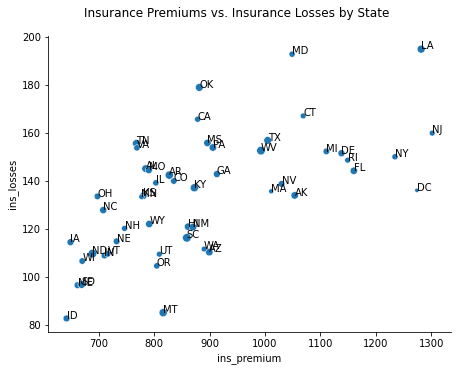

In [42]:
fg = sns.relplot(
    kind="scatter", 
    x=df_car_crashes[ins_premium_col_name],
    y=df_car_crashes.ins_losses,
    size=df_car_crashes[total_col_name]*size_factor,
    aspect=1.25,
    legend=False)
fg.fig.suptitle(title)
fg.fig.subplots_adjust(top=0.9)
for key, value in df_car_crashes.iterrows():
    fg.ax.annotate(
        key, 
        (
            value[ins_premium_col_name], 
            value[ins_losses_col_name]
        )
    )

#### 26) [P] Next, generate two interesting plots that show some relationships between variables in the data. Try to use as many variables as you can without creating chaos! Don't just throw in multiple variables for the sake of showing them, only include them if it makes sense to do so. Your aim is to derive meaning from your data. Good visualizations tell a story. Strive to use at least one additional variable as size, color, or shape in your data, so you can show more than just 2 variables on a single plot. Add titles, legends and label your axes as appropriate.<br/><br/>After each plot, create a markdown cell and briefly draw conclusions from your plot.

In [43]:
df_car_crashes.corr()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
total,1.000000,0.611548,0.852613,0.827560,0.956179,-0.199702,-0.036011
speeding,0.611548,1.000000,0.669719,0.588010,0.571976,-0.077675,-0.065928
alcohol,0.852613,0.669719,1.000000,0.732816,0.783520,-0.170612,-0.112547
not_distracted,0.827560,0.588010,0.732816,1.000000,0.747307,-0.174856,-0.075970
no_previous,0.956179,0.571976,0.783520,0.747307,1.000000,-0.156895,-0.006359
ins_premium,-0.199702,-0.077675,-0.170612,-0.174856,-0.156895,1.000000,0.623116
ins_losses,-0.036011,-0.065928,-0.112547,-0.075970,-0.006359,0.623116,1.000000


In [44]:
palette_type = "bwr"
fig_title = "# Fatal Collisions (FC) Drunk vs # FC Speeding Across US States"
x_label = "# Fatal Collissions Drunk in State"
y_label = "# Fatal Collisions Speeding in State"

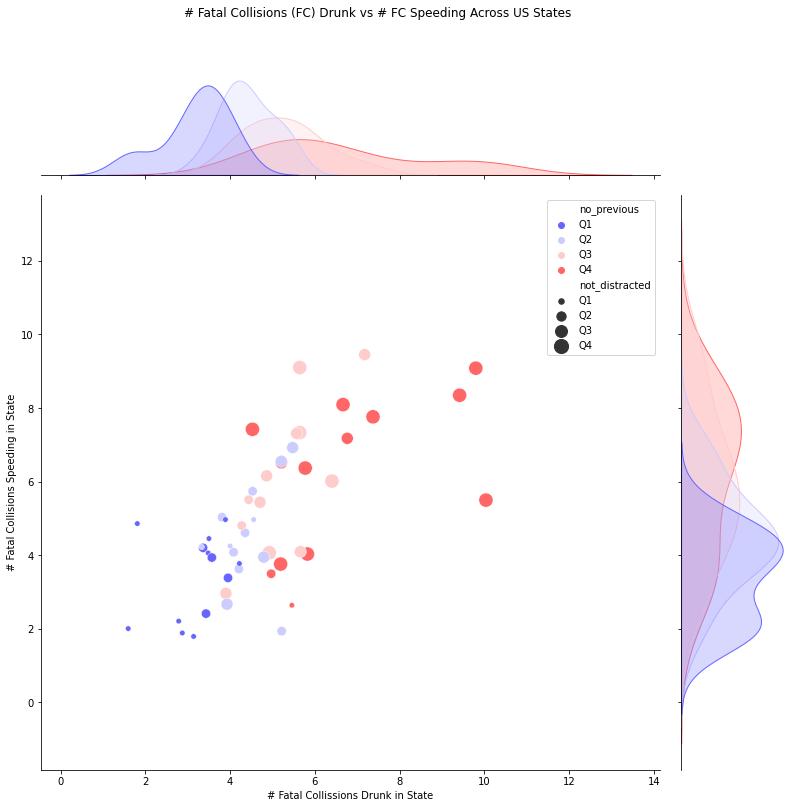

In [45]:
jg = sns.jointplot(
    kind="scatter",
    x=df_car_crashes[alcohol_col_name],
    y=df_car_crashes[speeding_col_name],
    hue=pd.qcut(
        x=df_car_crashes[no_previous_col_name],
        q=4,
        labels=["Q1", "Q2", "Q3", "Q4"]
    ),
    palette=palette_type,
    xlim=(0, df_car_crashes[alcohol_col_name].max()*1.05)
)

jg.fig.set_figwidth(12)
jg.fig.set_figheight(12)
jg.fig.suptitle(fig_title)
jg.fig.subplots_adjust(top=0.9)

# source: https://stackoverflow.com/questions/27005783/changing-color-and-marker-of-each-point-using-seaborn-jointplot/27007802
jg.ax_joint.cla()
sns.scatterplot(
    x=df_car_crashes[alcohol_col_name],
    y=df_car_crashes[speeding_col_name],
    hue = pd.qcut( 
        x=df_car_crashes[no_previous_col_name],
        q=4,
        labels=["Q1", "Q2", "Q3", "Q4"]
    ),
    size = pd.qcut(
        x=df_car_crashes[not_distracted_col_name],
        q=4,
        labels=["Q1", "Q2", "Q3", "Q4"]
    ),
    sizes=(200, 30),
    palette=palette_type,
    legend=True,
    ax=jg.ax_joint
)
jg.ax_joint.set_xlabel(x_label)
jg.ax_joint.set_ylabel(y_label)
jg.ax_joint.legend();

**Figure 1.** This figure displays (in the center) a scatter plot that shows the relationship between the number of fatal collisions while the driver was drunk versus the number of fatal collisions while the driver was speeding (across all of the states in the United States of America). Each point represents the statistic of a particular state, and such should be assumed when interpreting the remainder of the statistical analysis. Between these two variables, there is a positive relationship. 

Also, the number of drivers that had never been involved in a collision before and the number of drivers across these final collisions that were not distracted at the time of the collision have both been split up into quartiles and have been distinguished within the scatterplot by their color and size, respectively. We can further observe that the number of fatal collisions where the driver had no previous history of collisions were positive correlated with the number of fear of collision speeding and with the number of fatal collisions drunk. Also, the number of drivers where the driver was not distracted is negatively correlated with the number of fatal collisions that drivers made while drunk and with the number of fatal collisions the drivers made while speeding. 

There are also continuous distributions along both axes both on the top of the figure, which represents the distribution of the number of fatal collision cases while drunk and on the right of the figure which represents the distribution of the number of fatal collisions while speeding. The quartile-coloring scheme (number of fatal collissions where the driver had no previous history of collisions) distributions confirm the negative relationship with the number of fatal collisions where the driver was drunk and with the number of fatal collisions where the driver was speeding.

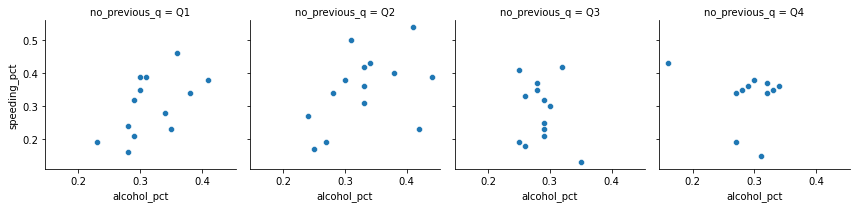

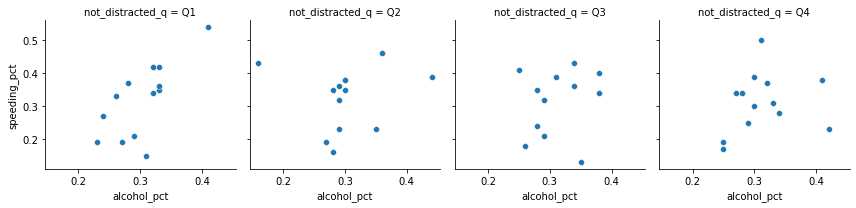

In [46]:
df_car_crashes_pct_and_q = pd.DataFrame(
    {
        "alcohol_pct": df_car_crashes[alcohol_col_name] / df_car_crashes[total_col_name],
        "speeding_pct": df_car_crashes[speeding_col_name] / df_car_crashes[total_col_name],
        "no_previous_q": pd.Categorical(
            pd.qcut(
                df_car_crashes[no_previous_col_name] / df_car_crashes[total_col_name],
                q=4,
                labels=["Q1", "Q2", "Q3", "Q4"]
            )
        ),
        "not_distracted_q": pd.Categorical(
            pd.qcut(
                df_car_crashes[not_distracted_col_name] / df_car_crashes[total_col_name],
                q=4,
                labels=["Q1", "Q2", "Q3", "Q4"]
            )
        )
    }
)

fg = sns.FacetGrid(
    data=df_car_crashes_pct_and_q,
    col="no_previous_q",
    sharex=True,
    sharey=True
)

fg.map(sns.scatterplot, 
       "alcohol_pct",
       "speeding_pct")

fg = sns.FacetGrid(
    data=df_car_crashes_pct_and_q,
    col="not_distracted_q",
    sharex=True,
    sharey=True
)

fg.map(sns.scatterplot, 
       "alcohol_pct",
       "speeding_pct")

Not the most useful analysis (did want to demonstrate that I at least tried; 'show your work'). Let's analyze some correlation coefficients now.

In [47]:
corr_coeffs=\
df_car_crashes.corr()\
.abs()\
.unstack()\
.sort_values(ascending=False, kind="quicksort")\

corr_coeffs_pruned = corr_coeffs[corr_coeffs!=1]
corr_coeffs_pruned.drop_duplicates(inplace=True)
corr_coeffs_pruned

no_previous     total             0.956179
total           alcohol           0.852613
not_distracted  total             0.827560
no_previous     alcohol           0.783520
                not_distracted    0.747307
alcohol         not_distracted    0.732816
speeding        alcohol           0.669719
ins_premium     ins_losses        0.623116
total           speeding          0.611548
not_distracted  speeding          0.588010
no_previous     speeding          0.571976
ins_premium     total             0.199702
not_distracted  ins_premium       0.174856
alcohol         ins_premium       0.170612
no_previous     ins_premium       0.156895
ins_losses      alcohol           0.112547
speeding        ins_premium       0.077675
ins_losses      not_distracted    0.075970
                speeding          0.065928
                total             0.036011
no_previous     ins_losses        0.006359
dtype: float64

Let's try analyzing the relationship of no_previous, alcohol, and/or not_distracted with total (>.80 correlation coefficient... starting point...)

In [48]:
# parameters
x_label = "Total # Fatal Collisions in State"
y_label = "# Drunk Driver Fatal Collisions in State"
fig_title = "# Drunk Driver Fatal Collisions (FC) vs. Total # FC in Each US State Across Quartile of # FC Not Distracted"

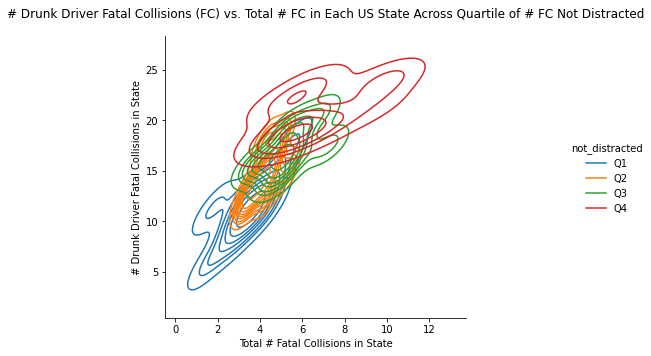

In [49]:
fg = sns.displot(
    data=df_car_crashes, 
    x="alcohol",  
    y="total",
    hue=pd.Categorical(
            pd.qcut(
                df_car_crashes[not_distracted_col_name],
                q=4,
                labels=["Q1", "Q2", "Q3", "Q4"]
            )
        ),
    kind="kde",
    legend=True
)

fg.ax.set_xlabel(x_label)
fg.ax.set_ylabel(y_label)
fg.fig.suptitle(fig_title)
fg.fig.subplots_adjust(top=0.9)
fg._legend.set_title(not_distracted_col_name)

**Figure 2.** This figure is a kernel density estimation plot, which is plotting a bivariate distribution capturing the total number of fatal collisions in a state versus the number of fatal collision with drunk drivers in that same state.

Once again, each point within the distribution represents a pair of statistics for one US state; all of the US states are captured in the distribution plotted above. 

It can be observed that the total number of fatal collisions in a state is positively correlated with the number of fatal collisions in a state where the driver was drunk. It can also be observed that the number of drivers that were not distracted in their fatal collisions in a state is positively correlated with both the total number of fatal collisions in that same state and with the number of fatal collisions where the driver was drunk in that same state. (If the numbers of drivers who were not distracted during the fatal collision across states were not positively correlated to the x and y axes in the figure above, it could potentially be inferred that the proportion of drivers involved in fatal collisions that are distracted in states with higher total numbers of fatal collisions or with higher numbers of fatal collisions with drunk drivers is higher than the proportion of drivers involved in fatal collisions that are distracted in states with lower total numbers of fatal collision or with lower numbers of fatal collisions with drunk drivers.)

#### 27) [P] Run a full PCA on the z_score transformed data. Set ```n_components``` to be the same number of columns as the data. Be sure to fit the data to your PCA model, and then output the components, explained variance, and the explained variance ratio.

In [50]:
# parameters
n_components = len(df_car_crashes.columns)

In [51]:
df_car_crashes_zscores = df_car_crashes.apply(zscore)
pca = PCA(n_components=n_components)
pca.fit(df_car_crashes_zscores)

print("pca components: ")
display(pd.DataFrame(
    pca.components_,
    index=range(1, n_components+1),
    columns=df_car_crashes_zscores.columns
))
print("\nexplained variance: " + str(pca.explained_variance_))
print("\nexplained variance ratio: " + \
      str(pca.explained_variance_ratio_))

pca components: 


,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
1,0.479471,0.375347,0.454376,0.438033,0.457034,-0.130832,-0.069960
2,0.068938,0.076585,0.033458,0.042375,0.096129,0.685227,0.712524
3,-0.269088,0.818269,0.082933,-0.126168,-0.317988,0.256142,-0.261735
4,0.038956,-0.363749,0.148344,0.171266,0.039481,0.656396,-0.618399
5,0.145977,-0.022828,0.354798,-0.856469,0.336110,0.042145,-0.063272
6,-0.169705,-0.224792,0.783768,0.085105,-0.504012,-0.115773,0.178052
7,0.800825,0.017848,-0.152858,-0.142478,-0.558754,0.041266,-0.028050



explained variance: [4.0942308  1.6095732  0.56161403 0.35753958 0.2863854  0.20263316
 0.02802383]

explained variance ratio: [0.57342168 0.22543042 0.07865743 0.05007557 0.04011    0.02837999
 0.00392491]


#### 28) [M] Use your intuition – what do the weights of the first couple of components suggest where most of the variance in the data is coming from?

In [52]:
df_car_crashes.columns

Index(['total', 'speeding', 'alcohol', 'not_distracted', 'no_previous',
       'ins_premium', 'ins_losses'],
      dtype='object')

Most of the variance is coming from the first principal component (responsible for over 50 percent f the variance in the data set). The weights in this first principal component suggest that most of the variance in the first principal component come from the following variables (sorted in descending order by first principal component weightage): total, no_previous, alcohol, not_distracted, speeding, which appear to be positively correlated with one another. Additionally, looking at the second principal component, which captures about 23 percent of the variance of the data set, the average insurance premiums and average insurance losses, which appear to be responsible for the most variance in the second principal component, also appear to be positively correlated with one another. 

#### 29) [P] Create a plot of the cumulative sum of the explained variance. How many components will get you to 90% of the explained variance?

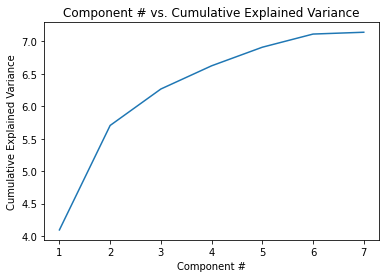

In [53]:
ax = sns.lineplot(x=range(1, n_components+1),
                  y=np.cumsum(pca.explained_variance_))
ax.set_xlabel("Component #")
ax.set_ylabel("Cumulative Explained Variance")
ax.set_title("Component # vs. Cumulative Explained Variance");

In [54]:
# sns.lineplot(x=range(1, n_components+1),
#                   y=np.cumsum(pca.explained_variance_ratio_))
# printing cumulative sum of explained variance ratio
print(np.cumsum(pca.explained_variance_ratio_))

[0.57342168 0.7988521  0.87750953 0.9275851  0.9676951  0.99607509
 1.        ]


It will take four components to get to (at least) 90% of the explained variance; the first four components together will capture about 93% of the variance.

#### 30) [P] Transform the z_score transformed data using your PCA model (i.e. using the transform function of the pca object.)<br/><br/>(NOTE: I often just store the transformed data temporarily as some arbitrary variable, X, to make it easier to manipulate the data for plotting.)

In [55]:
X = pca.transform(df_car_crashes_zscores)

#### 31) [P] Generate a 2D plot using the first two principal components as your x and y coordinates. Be sure to label each point, and label your axes as component 1 and component 2, respectively.

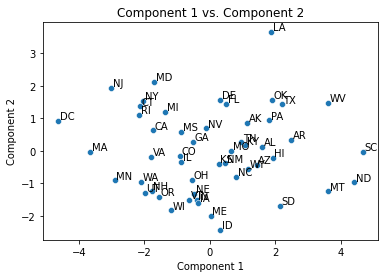

In [64]:

ax = sns.scatterplot(x=X[:,0], y=X[:,1])
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title("Component 1 vs. Component 2")
for i in range(len(df_car_crashes_zscores.index)):
    plt.text(x=X[i,0]+0.05, 
             y=X[i,1]+0.05, 
             s=df_car_crashes_zscores.index[i])


In [ ]:
df_car_crashes_zscores.index.to_numpy(dtype=str)

#### 32) [M] Compare the states you reported as potential outliers above to those that appear to be outliers from your plot. Do the same results seem to hold?

Answer from before: "From my analysis, Washington, D.C. (DC); North Dakota (ND), South Carolina (SC), and Louisiana (LA) seem to be the strongest outliers due to having the highest mean distances to other states within the United States."

Yes, the same results appear to hold; the points for Washington DC, North Dakota, South Carolina, Louisiana all appear at the edges of the graph (or, in another words, at the edges of the ranges of the data set along one of the principal components plotted above).

#### 33) [P] Read how to generate a 3D scatterplot in seaborn or plotly, and use it to generate a scatterplot of the first 3 components.

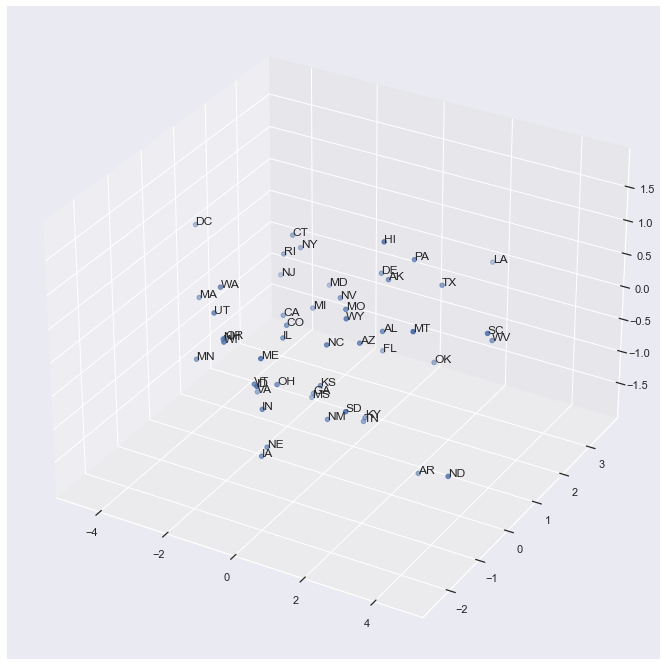

In [76]:
# apparently, seaborn doesn't come with 3d scatter plotting;
# it relies on matplotlib to do the 3d plotting
# source: https://stackabuse.com/seaborn-scatter-plot-tutorial-and-examples/

# source: https://stackabuse.com/seaborn-scatter-plot-tutorial-and-examples/
sns.set(style = "darkgrid")

# source: https://stackoverflow.com/questions/52285104/3d-scatterplots-in-python-with-hue-colormap-and-legend
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], 
           X[:,1], 
           X[:,2])
for i in range(len(df_car_crashes_zscores.index)):
    ax.text(X[i,0], 
            X[i,1],
            X[i,2],
            s=df_car_crashes_zscores.index[i])

#### 34) [M] Do the same outliers still stand out?

Yes, the same outliers still stand out. The points representing the principal component coordinates for Washington DC, Louisiana, North Dakota, and South Carolina can still be seen on the 3-D scatterplot above  as being far from the origin (the back corner, i.e. where the three planes intersect in the graph).